# BOTS quickstart

# <a href="https://colab.research.google.com/github/reml-lab/bots/blob/main/examples/BOTS_quickstart.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This is an official notebook for the paper **BOTS: Batch Bayesian Optimization of Extended Thompson Sampling for Severely Episode-Limited RL Settings**, Karine and Marlin, 2024. This paper was accepted at NeurIPS 2024 Workshop on Bayesian Decision-making and Uncertainty 2024.

**Paper and poster links**:
+ [arXiv link](https://arxiv.org/pdf/2412.00308)
+ [paper link](https://github.com/reml-lab/bots/tree/main/BOTS_paper.pdf)
+ [poster](https://github.com/reml-lab/bots/tree/main/BOTS_poster.pdf)

**Paper abstract**:
In settings where the application of reinforcement learning (RL) requires running real-world trials, including the optimization of adaptive health interventions, the number of episodes available for learning can be severely limited due to cost or time constraints. In this setting, the bias-variance trade-off of contextual bandit methods can be significantly better than that of more complex full RL methods. However, Thompson sampling bandits are limited to selecting actions based on distributions of immediate rewards. In this paper, we extend the linear Thompson sampling bandit to select actions based on a state-action utility function consisting of the Thompson sampler's estimate of the expected immediate reward combined with an action bias term. We use batch Bayesian optimization over episodes to learn the action bias terms with the goal of maximizing the expected return of the extended Thompson sampler. The proposed approach is able to learn optimal policies for a strictly broader class of Markov decision processes (MDPs) than standard Thompson sampling. Using an adaptive intervention simulation environment that captures key aspects of behavioral dynamics, we show that the proposed method can significantly out-perform standard Thompson sampling in terms of total return, while requiring significantly fewer episodes than standard value function and policy gradient methods.

**This notebook**: we describe how to use BOTS.

# Initialize Code

In [18]:
!pip install batchBOTS

In [10]:
!pip install botorch > a_botorch.log

In [11]:
import botorch
import warnings
warnings.filterwarnings("ignore")
# botorch version = 0.15.1 as of Aug 25 2025
botorch.__version__

'0.15.1'

In [12]:
import numpy as np
import pandas as pd
import torch
import timeit
import os
from BOTS.agents import ThompsonSamplingBayesLRAgent
from BOTS.batch_agents import BatchAgentTS, BatchAgentBO
from BOTS.experiments import generate_seeds, create_B_schedule, create_env_list, plot_batch_results
from BOTS.utils import get_x_bounds, set_random_seed

# Code to run experiments

In [13]:
def create_agent(chosen_agent_name, chosen_BO_PARAMS, matrix_seeds_agent, B_schedule, trial, b_update_TS_priors):
  """Create and return a new agent with given settings."""
  # base TS agent settings
  TS_agent_settings = default_TS_settings.copy()
  TS_agent_settings['chosen_obs_names'] = CHOSEN_OBS_NAMES
  TS_agent_settings['n_actions'] = N_ARMS
  TS_agent_settings['bo_params'] = None
  TS_agent_settings['beta_coeffs'] = None

  if (chosen_agent_name.find('TS') >= 0) and (chosen_agent_name.find('BO') < 0):
    # Thompson Sampling agent
    if (chosen_agent_name == 'TS') or (chosen_agent_name == 'TS_prior'):
      # TS = uninformative prior; TS_prior = informative prior
      TS_agent_settings['bo_params'] = 'NOT USED'
      TS_agent_settings['beta_coeffs'] = None
    else:
      assert(1==2), f'error TS agent_name = {agent_name} does not exist in create_agents()!'
    new_seeds = matrix_seeds_agent[trial][:][:]
    new_agent = BatchAgentTS(chosen_agent_name, new_seeds, B_schedule, TS_agent_settings)

    if b_update_TS_priors:
      # initialize priors
      mean_values = np_TS_mean
      cov_matrix  = np_TS_cov
      for agent_i in range(len(new_agent.agents)):
        for arm in range(N_ARMS):
          new_agent.agents[agent_i].prior_coeff_mu_b[arm]      = mean_values[arm][0]
          new_agent.agents[agent_i].prior_coeff_mu_w[arm]      = mean_values[arm][1:]
          new_agent.agents[agent_i].prior_coeff_sigma[arm]     = cov_matrix[arm]
          new_agent.agents[agent_i].post_coeff_mu_dict[arm]    = mean_values[arm]
          new_agent.agents[agent_i].post_coeff_sigma_dict[arm] = cov_matrix[arm]

  elif (chosen_agent_name.find('BO') >= 0) or (chosen_agent_name.find('Sobol') >= 0):
    # Bayesian Optimization agent
    BO_default_TS_settings = TS_agent_settings.copy()
    BO_default_TS_settings['bo_params'] = chosen_BO_PARAMS
    BO_agent_settings = {}
    BO_agent_settings['default_TS_settings'] = BO_default_TS_settings
    BO_agent_settings['dtype'] = dtype
    BO_agent_settings['device'] = device
    BO_agent_settings['trial'] = trial
    BO_agent_settings['x_dim'] = x_dim
    BO_agent_settings['x_bounds'] = x_bounds
    BO_agent_settings['x_bounds_NORMALIZED'] = x_bounds_NORMALIZED
    BO_agent_settings['num_restarts'] = NUM_RESTARTS
    BO_agent_settings['raw_samples'] = RAW_SAMPLES
    new_seeds = matrix_seeds_agent[trial][:][:]
    new_agent = BatchAgentBO(chosen_agent_name, new_seeds, B_schedule, BO_agent_settings, n_candidates_for_TS=256)
  else:
    # invalid agent name
    assert(1==2), f'error agent_name = {agent_name} does not exist in create_agents()!'

  return new_agent


def run_trial(chosen_agent_name, chosen_BO_PARAMS, matrix_seeds_agent, matrix_seeds_env, trial, ROUNDS, B_schedule, STEPS,
              results, actions_all, lengths_all, disengagement_all, betas_all, info_dict,
              np_TS_mean, np_TS_cov, b_train=True):
  """Run one trial across multiple rounds with the chosen agent."""
  # Run one trial across multiple rounds
  b_update_TS_priors = False
  if chosen_BO_PARAMS is not None:
    if chosen_BO_PARAMS in ['betas3', 'betas3 sigmaYs1', 'betas3 sigmaYs4']:
      b_update_TS_priors = True
  else:
    if chosen_agent_name == 'TS_prior':
      b_update_TS_priors = True

  if b_update_TS_priors and b_version_B:
    # Dataframe to store new data for updating priors
    column_names = ['batch', 'step'] + CHOSEN_OBS_NAMES + ['action', 'reward', 'done']
    df_new = pd.DataFrame(columns=column_names)

  # create agent
  new_agent = create_agent(chosen_agent_name, chosen_BO_PARAMS, matrix_seeds_agent, B_schedule, trial, b_update_TS_priors)

  if b_update_TS_priors:
    # initialize TS priors at round 0
    mean_values = np_TS_mean
    cov_matrix  = np_TS_cov

  FIRST_ROUND_BO = 1 if b_update_TS_priors else 0

  for round in range(FIRST_ROUND_BO, ROUNDS):
    if b_update_TS_priors and b_version_B:
      COUNT_df_new = 0  # reset counter
    start_round_timer = timeit.default_timer()
    chosen_BATCH_SIZE = int(B_schedule[round])

    # create batch of environments
    env_list = create_env_list(seeds_env=matrix_seeds_env, trial=trial, chosen_round=round, batch_size=chosen_BATCH_SIZE,
                               chosen_n_version=CHOSEN_n_version, chosen_obs_names=CHOSEN_OBS_NAMES,
                               CHOSEN_δh=CHOSEN_δh, CHOSEN_εh=CHOSEN_εh, CHOSEN_δd=CHOSEN_δd, CHOSEN_εd=CHOSEN_εd,
                               chosen_sigma=CHOSEN_env_sigma, D_threshold=D_threshold)

    if b_update_TS_priors:
      # update priors at start of round
      for agent_i in range(len(new_agent.agents)):
        for arm in range(N_ARMS):
          new_agent.agents[agent_i].prior_coeff_mu_b[arm]      = mean_values[arm][0]
          new_agent.agents[agent_i].prior_coeff_mu_w[arm]      = mean_values[arm][1:]
          new_agent.agents[agent_i].prior_coeff_sigma[arm]     = cov_matrix[arm]
          new_agent.agents[agent_i].post_coeff_mu_dict[arm]    = mean_values[arm]
          new_agent.agents[agent_i].post_coeff_sigma_dict[arm] = cov_matrix[arm]

        if chosen_BO_PARAMS is not None:
          # store beta values
          betas_all[trial,round,agent_i] = new_agent.agents[agent_i].beta_coeffs.detach().numpy()

    # initialize batch state
    done_list = [False] * chosen_BATCH_SIZE
    obs_list = [None] * chosen_BATCH_SIZE
    for batch in range(chosen_BATCH_SIZE):
      obs_list[batch], NOT_USED = env_list[batch].reset()
    rewards_all = np.empty((chosen_BATCH_SIZE, STEPS)); rewards_all[:] = np.nan

    for step in range(STEPS):
      for batch in range(chosen_BATCH_SIZE):

        # record trial-round-batch-step info
        info_dict['trial'] = trial
        info_dict['r'] = round
        info_dict['b'] = batch
        info_dict['s'] = step
        new_agent.info_dict = info_dict

        if not done_list[batch]:
          # get values before action
          C_value = env_list[batch].get_C()
          L_value = env_list[batch].get_L()
          P_value = env_list[batch].get_P()
          H_value = env_list[batch].get_H()
          D_value = env_list[batch].get_D()

          # agent picks action
          action = new_agent.choose_action(obs_list[batch], batch)
          obs_, reward, done, NOT_USED, info = env_list[batch].step(action)

          # update agent
          rewards_all[batch][step] = reward
          new_agent.update_batch(b_train, info_dict, obs_list[batch], action, reward, obs_, done, batch)
          done_list[batch] = done
          obs_list[batch] = obs_

          if b_update_TS_priors and b_version_B:
            # save data for MRT prior update
            row_data = []
            for var_name in CHOSEN_OBS_NAMES:
              if var_name == 'C': row_data.append(C_value)
              if var_name == 'L': row_data.append(L_value)
              if var_name == 'P': row_data.append(P_value)
              if var_name == 'H': row_data.append(H_value)
              if var_name == 'D': row_data.append(D_value)
            df_new.loc[len(df_new)] = [int(batch), int(step)]+row_data+[int(action), reward, int(done)]
            COUNT_df_new += 1

          if chosen_BO_PARAMS == 'betas3':
            # store extra info for betas3 plots
            actions_all[trial,round,batch,step] = action
            lengths_all[trial,round,batch,step] = 1
            disengagement_all[trial,round,batch,step] = env_list[batch].get_D()

      # end step updates
      new_agent.update_step(b_train, step)
      if np.all(done_list):
        break

    # compute round reward
    results[trial][round] = np.nansum(np.nansum(rewards_all, axis=-1), axis=-1)
    new_agent.update_round(b_train, info_dict, STEPS, round)

    if b_update_TS_priors and b_version_B:
      # compute new TS priors from MRT data
      if round > FIRST_ROUND_BO:
        df_new['batch']  = df_new['batch'].astype(int)
        df_new['step']   = df_new['step'].astype(int)
        df_new['action'] = df_new['action'].astype(int)
        df_new['done']   = df_new['done'].astype(int)
        for var_name in CHOSEN_OBS_NAMES:
          if var_name == 'C': df_new[var_name] = df_new[var_name].astype(int)
          if var_name == 'L': df_new[var_name] = df_new[var_name].astype(int)
          if var_name == 'A': df_new[var_name] = df_new[var_name].astype(int)
          if var_name == 'B': df_new[var_name] = df_new[var_name].astype(int)

        str_info = f't{trial} r{round}'
        if round > FIRST_ROUND_BO+1:
          NOT_USED, np_TS_mean, np_TS_cov = get_new_TS_priors_using_MRT(
              b_new_MRT=False, df_all=df_MRT, b_insert_new_data=True, df_new=df_new, str_info=str_info)
          mean_values = np_TS_mean
          cov_matrix  = np_TS_cov

    # log round time
    duration_round = timeit.default_timer() - start_round_timer
    minutes_round = int(duration_round//60); seconds_round = int(duration_round - minutes_round*60.)
    if (round == 0) or (round == 1) or (round % max(1,(ROUNDS//5)) == 0):
      env_seeds_display = [env_list[b_index].seed for b_index in range(chosen_BATCH_SIZE)]
      return_so_far = results[trial][round]

  return results, actions_all, lengths_all, disengagement_all, betas_all, info_dict


def run_experiment(chosen_agent_name, chosen_BO_PARAMS, chosen_TRIALS, chosen_ROUNDS, chosen_BATCH_SIZE, chosen_STEPS, chosen_N_MRT, chosen_N_INIT, chosen_n_version, chosen_obs_names, b_update_stdout,
                   np_TS_mean, np_TS_cov):
  """Run a full experiment (all trials and rounds)."""
  str_TRB = 'T{} R{} B{}'.format(chosen_TRIALS, chosen_ROUNDS, chosen_BATCH_SIZE)
  info_dict = {'TRB':str_TRB, 'ROUNDS':chosen_ROUNDS}
  print(f'running {chosen_agent_name} experiments (trials={chosen_TRIALS} TRB={str_TRB})...')

  # generate seeds and batch schedule
  matrix_seeds_agent, matrix_seeds_env = generate_seeds(chosen_TRIALS, chosen_ROUNDS, chosen_BATCH_SIZE, chosen_N_INIT, init_seed=0)
  B_schedule = create_B_schedule(chosen_ROUNDS, chosen_BATCH_SIZE, chosen_N_MRT, chosen_N_INIT)

  # allocate storage
  results = np.empty((chosen_TRIALS, chosen_ROUNDS)); results[:] = np.nan
  actions_all = None; lengths_all = None; disengagement_all = None; betas_all = None
  if chosen_BO_PARAMS is not None:
    if chosen_BO_PARAMS.find('betas') >= 0:
      actions_all = np.empty((chosen_TRIALS, chosen_ROUNDS, max(chosen_BATCH_SIZE, chosen_N_INIT), chosen_STEPS, 1))
      lengths_all = np.empty((chosen_TRIALS, chosen_ROUNDS, max(chosen_BATCH_SIZE, chosen_N_INIT), chosen_STEPS, 1))
      disengagement_all = np.empty((chosen_TRIALS, chosen_ROUNDS, max(chosen_BATCH_SIZE, chosen_N_INIT), chosen_STEPS, 1))
      betas_all = np.empty((chosen_TRIALS, chosen_ROUNDS, max(chosen_BATCH_SIZE, chosen_N_INIT), x_dim))
      actions_all[:] = np.nan; lengths_all[:] = np.nan; disengagement_all[:] = np.nan; betas_all[:] = np.nan

  for trial in range(chosen_TRIALS):
    # run one trial
    start_trial = timeit.default_timer()
    set_random_seed(trial)

    results, actions_all, lengths_all, disengagement_all, betas_all, info_dict = run_trial(
        chosen_agent_name, chosen_BO_PARAMS, matrix_seeds_agent, matrix_seeds_env, trial, chosen_ROUNDS, B_schedule, chosen_STEPS,
        results, actions_all, lengths_all, disengagement_all, betas_all, info_dict,
        np_TS_mean, np_TS_cov)

    # log timing
    duration_trial = timeit.default_timer() - start_trial
    minutes_trial = int(duration_trial//60); seconds_trial = int(duration_trial - minutes_trial*60.)
    trial_message = f'finished {chosen_agent_name} {"".join(chosen_obs_names)} env{chosen_n_version} ({BO_PARAMS}) trial{trial} duration = {duration_trial:.1f} sec'
    print(trial_message)

  def shorten_str(str_input): return str(str_input).replace('.','_').replace(' ','')
  # save outputs
  if chosen_BO_PARAMS is None:
    outfile = output_folder + '/npz_RL_{}'.format(shorten_str(output_detail)) + '_{}.npz'.format(chosen_agent_name)
  else:
    outfile = output_folder + '/npz_BO_{}_{}'.format(chosen_BO_PARAMS.replace(' ',''), shorten_str(output_detail)) + '_{}.npz'.format(chosen_agent_name)
  np.savez(outfile, result_y_train_divide_by_batch = results,
                    betas_all = betas_all, actions_all=actions_all, lengths_all=lengths_all)
  return results, B_schedule


# Code to run MRT

In [14]:
def get_new_TS_priors_using_MRT(b_new_MRT, df_all, b_insert_new_data, df_new=None, str_info='init'):
  """Run MRT experiment to collect data, update Bayesian Linear Regression
  priors for Thompson Sampling, and return updated priors (mean, cov)."""
  if b_new_MRT:
    # MRT setup
    chosen_trials = 1; chosen_rounds = 1; chosen_batch_size = N_MRT
    str_TRB = 'T{} R{} B{}'.format(chosen_trials, chosen_rounds, chosen_batch_size)
    info_dict = {'TRB':str_TRB, 'ROUNDS':chosen_rounds}

    # seeds and schedule
    matrix_seeds_agent, matrix_seeds_env = generate_seeds(chosen_trials, chosen_rounds, chosen_batch_size, N_MRT, init_seed=0)
    B_schedule_MRT = create_B_schedule(2, None, chosen_batch_size, 0)

    print('{} start MRT experiment {} N_MRT={} {}...'.format(str_info, str_TRB, N_MRT, ''.join(CHOSEN_OBS_NAMES)))

    # init arrays
    Xs = np.empty((chosen_trials, chosen_rounds, max(B_schedule_MRT), STEPS)); Xs[:] = np.nan
    Hs = np.empty_like(Xs); Ds = np.empty_like(Xs)
    df_dict = {}

    # run trials/rounds
    for trial_MRT in range(chosen_trials):
      set_random_seed(trial_MRT)
      for round_MRT in range(chosen_rounds):
        str_df_key = 't{} r{}'.format(trial_MRT, round_MRT)
        cols = ['batch','step']+CHOSEN_OBS_NAMES+['action','reward','done']
        df_dict[str_df_key] = pd.DataFrame(columns=cols)

        chosen_BATCH_SIZE = int(B_schedule_MRT[round_MRT])

        # create envs
        env_list = create_env_list(
            seeds_env=matrix_seeds_env, trial=trial_MRT, chosen_round=round_MRT, batch_size=chosen_BATCH_SIZE,
            chosen_n_version=CHOSEN_n_version, chosen_obs_names=CHOSEN_OBS_NAMES,
            CHOSEN_δh=CHOSEN_δh, CHOSEN_εh=CHOSEN_εh, CHOSEN_δd=CHOSEN_δd, CHOSEN_εd=CHOSEN_εd,
            chosen_sigma=CHOSEN_env_sigma, D_threshold=D_threshold)

        done_list = [False]*chosen_BATCH_SIZE
        obs_list  = [env.reset()[0] for env in env_list]

        # rollout steps
        for step_MRT in range(STEPS):
          for batch_MRT in range(chosen_BATCH_SIZE):
            info_dict.update({'trial':trial_MRT,'r':round_MRT,'b':batch_MRT,'s':step_MRT})

            if not done_list[batch_MRT]:
              # record obs
              C_value = env_list[batch_MRT].get_C()
              L_value = env_list[batch_MRT].get_L()
              P_value = env_list[batch_MRT].get_P()
              H_value = env_list[batch_MRT].get_H()
              D_value = env_list[batch_MRT].get_D()

              # random action
              action = np.random.choice(N_ARMS)
              obs_, reward, done, _, info = env_list[batch_MRT].step(action)

              done_list[batch_MRT] = done
              obs_list[batch_MRT] = obs_

              # build row
              row_data = []
              for var in CHOSEN_OBS_NAMES:
                if var == 'C': row_data.append(C_value)
                if var == 'L': row_data.append(L_value)
                if var == 'P': row_data.append(P_value)
                if var == 'H': row_data.append(H_value)
                if var == 'D': row_data.append(D_value)

              df_dict[str_df_key].loc[len(df_dict[str_df_key])] = [int(batch_MRT), int(step_MRT)] + row_data + [int(action), reward, int(done)]

          if np.all(done_list): break

    # clean DataFrame
    str_keys = list(df_dict.keys())
    df_all = df_dict[str_keys[0]]
    df_all = df_all.astype({'batch':int,'step':int,'action':int,'done':int})
    for var in CHOSEN_OBS_NAMES:
      if var in ['C','L','A','B']: df_all[var] = df_all[var].astype(int)

  # merge new data if needed
  if b_insert_new_data:
    df_all = pd.concat([df_all, df_new], axis=0, ignore_index=True)

  # group by arm
  unique_actions = df_all["action"].unique()
  df_per_a = df_all.groupby(['action'])
  Data = {arm: (df_per_a.get_group(arm) if arm in unique_actions else np.array([])) for arm in range(N_ARMS)}

  # setup BLR priors
  n_arms = N_ARMS; agent_seed = 0; input_dims = len(CHOSEN_OBS_NAMES)
  PRIOR_COEFF_MU_b = float(default_COEFF_MU_b)
  PRIOR_COEFF_MU_w = np.ones(input_dims)*default_COEFF_MU_w
  PRIOR_COEFF_SIGMA = np.eye(input_dims+1)*default_COEFF_SIGMA
  prior_coeff_mu_b = {arm: PRIOR_COEFF_MU_b for arm in range(n_arms)}
  prior_coeff_mu_w = {arm: PRIOR_COEFF_MU_w for arm in range(n_arms)}
  prior_coeff_sigma = {arm: PRIOR_COEFF_SIGMA for arm in range(n_arms)}

  # init TS agent
  chosen_agent = ThompsonSamplingBayesLRAgent(
      n_arms=N_ARMS, seed=agent_seed, sigma_y=default_SIGMA_Y, beta_coeffs=None,
      prior_coeff_mu_b=prior_coeff_mu_b, prior_coeff_mu_w=prior_coeff_mu_w,
      prior_coeff_sigma=prior_coeff_sigma, bo_params=None, max_beta=None, chosen_beta_a=-1)

  # update posteriors per arm
  for arm in range(N_ARMS):
    prev_mu = chosen_agent.post_coeff_mu_dict[arm]
    prev_sigma = chosen_agent.post_coeff_sigma_dict[arm]
    prev_sigma_inv = np.linalg.inv(chosen_agent.previous_post_coeff_sigma)
    if arm in unique_actions:
      X = Data[arm][CHOSEN_OBS_NAMES].assign(intercept=1.)
      X = X[['intercept']+list(CHOSEN_OBS_NAMES)].values
      Y = Data[arm]['reward'].values
      chosen_agent.post_coeff_mu_dict[arm], chosen_agent.post_coeff_sigma_dict[arm] = \
          chosen_agent.calculate_posterior_mean_sigma(chosen_agent.sigma_y, prev_mu, prev_sigma_inv, X, Y)

  # collect TS priors
  np_TS_mean = np.array([chosen_agent.post_coeff_mu_dict[arm] for arm in range(N_ARMS)])
  np_TS_cov  = np.array([chosen_agent.post_coeff_sigma_dict[arm] for arm in range(N_ARMS)])

  # save priors
  outfile = output_folder+'/npz_TS_prior_mean_exact_env{}_{}_TS{}.npz'.format(CHOSEN_n_version, ''.join(CHOSEN_OBS_NAMES), TS_update_version)
  np.savez(outfile, mean=np_TS_mean)
  outfile = output_folder+'/npz_TS_prior_cov_exact_env{}_{}_TS{}.npz'.format(CHOSEN_n_version, ''.join(CHOSEN_OBS_NAMES), TS_update_version)
  np.savez(outfile, cov_matrix=np_TS_cov)

  return df_all, np_TS_mean, np_TS_cov

# Configure

In [15]:
# Experiment setup
# BO_PARAMS can be: 'betas3'=[b1,b2,b3], 'betas3 sigmaYs1'=[b1,b2,b3,sY], 'betas3 sigmaYs4'=[b1,b2,b3,sY0..sY3], None=RL
# TS versions can be: A=Fixed prior (set b_version_B to False), B=Updated prior (set b_version_B to True)
b_version_B = True
BO_PARAMS = 'betas3'
ROUNDS = 120; BATCH_SIZE = 1; TRIALS = 5

N_MRT = 10; N_INIT = 10; CHOSEN_TS_MAX_BETA = -100.
BO_BETA_MIN = 0.; BO_BETA_MAX = 1.; STEPS = 50; N_ARMS = 4
ROUNDS = ROUNDS+2  # adjust rounds
fig_size=(4,3.2); y_lim=(0,3500)

# Env params
CHOSEN_n_version = 0; CHOSEN_OBS_NAMES = ['C','H','D']; CHOSEN_env_sigma = .6
CHOSEN_δh=0.1; CHOSEN_εh=0.05; CHOSEN_δd=0.1; CHOSEN_εd=0.4; D_threshold=0.99
input_dims = len(CHOSEN_OBS_NAMES)

# Default TS priors
default_COEFF_MU_w = 0.; default_COEFF_MU_b = 0.
default_COEFF_SIGMA = 100.; default_SIGMA_Y = 25
SIGMA_Y = float(default_SIGMA_Y) # Noise σy
if BO_PARAMS is not None and BO_PARAMS.find('sigmaYs4') >= 0:
  SIGMA_Y = [float(default_SIGMA_Y) for _ in range(N_ARMS)]
PRIOR_COEFF_MU_b = float(default_COEFF_MU_b)
PRIOR_COEFF_MU_w = np.ones(input_dims)*default_COEFF_MU_w
PRIOR_COEFF_SIGMA = np.eye(input_dims+1)*default_COEFF_SIGMA
default_TS_settings = {
  'sigma_y': SIGMA_Y, 'coeff_mu_w': default_COEFF_MU_w,
  'coeff_mu_b': default_COEFF_MU_b, 'coeff_sigma': default_COEFF_SIGMA,
  'prior_coeff_mu_w': PRIOR_COEFF_MU_w, 'prior_coeff_mu_b': PRIOR_COEFF_MU_b,
  'prior_coeff_sigma': PRIOR_COEFF_SIGMA, 'max_beta': CHOSEN_TS_MAX_BETA
}

# Experiment settings dict
experiment_settings = {
  'chosen_BO_PARAMS': BO_PARAMS, 'chosen_TRIALS': TRIALS,
  'chosen_ROUNDS': ROUNDS, 'chosen_BATCH_SIZE': BATCH_SIZE,
  'chosen_STEPS': STEPS, 'chosen_N_INIT': N_INIT,
  'chosen_n_version': CHOSEN_n_version, 'chosen_obs_names': CHOSEN_OBS_NAMES,
  'b_update_stdout': False
}
experiment_settings_plot = experiment_settings.copy()
experiment_settings['np_TS_mean'] = None; experiment_settings['np_TS_cov'] = None
experiment_settings['chosen_N_MRT'] = N_MRT
experiment_settings['chosen_BO_PARAMS'] = BO_PARAMS  # store chosen BO params

# Output setup
output_folder = 'output'
if not os.path.exists(output_folder): os.makedirs(output_folder)
str_CHOSEN_OBS_NAMES = ''.join(CHOSEN_OBS_NAMES)
TS_update_version = 'B' if b_version_B else 'A'
output_detail = 'T{}_R{}_B{}_env{}_TS{}'.format(TRIALS, ROUNDS, BATCH_SIZE, CHOSEN_n_version, TS_update_version)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dtype = torch.double
NUM_RESTARTS = 20
RAW_SAMPLES = 256
SIGMA_Y_MIN = 0.1; SIGMA_Y_MAX = 50.   # σy bounds
MU_MIN = -200.; MU_MAX = 200.          # μ bounds
U_DIAG_MIN = 0.1; U_DIAG_MAX = 10.     # diag(U) bounds
U_TOP_MIN  = -10.; U_TOP_MAX  = 10.    # off-diag(U) bounds

# Get x_dim and x_bounds (normalized bounds)
setting_name = BO_PARAMS
x_dim, x_bounds = get_x_bounds(  # param space bounds
  BO_PARAMS, BO_BETA_MIN, BO_BETA_MAX,
  SIGMA_Y_MIN, SIGMA_Y_MAX, MU_MIN, MU_MAX,
  U_DIAG_MIN, U_DIAG_MAX, U_TOP_MIN, U_TOP_MAX,
  device, dtype
)
x_bounds_NORMALIZED = torch.stack([
  torch.zeros(x_dim, dtype=dtype, device=device),
  torch.ones(x_dim, dtype=dtype, device=device)
])

# Run MRT

In [16]:
# Run MRT to obtain new Thompson Sampling priors
df_MRT, np_TS_mean, np_TS_cov = get_new_TS_priors_using_MRT(
    b_new_MRT=True,          # flag to generate new MRT data
    df_all=None,             # no existing data provided
    b_insert_new_data=False, # do not insert new data
    str_info='MRT'           # info string for logging
)

# Update experiment settings with new TS priors
experiment_settings['np_TS_mean'] = np_TS_mean
experiment_settings['np_TS_cov'] = np_TS_cov

MRT start MRT experiment T1 R1 B10 N_MRT=10 CHD...


# Run BOTS

running TuRBO-TS experiments (trials=5 TRB=T5 R122 B1)...
finished TuRBO-TS CHD env0 (betas3) trial0 duration = 61.0 sec
finished TuRBO-TS CHD env0 (betas3) trial1 duration = 53.8 sec
finished TuRBO-TS CHD env0 (betas3) trial2 duration = 52.0 sec
finished TuRBO-TS CHD env0 (betas3) trial3 duration = 51.1 sec
finished TuRBO-TS CHD env0 (betas3) trial4 duration = 54.2 sec


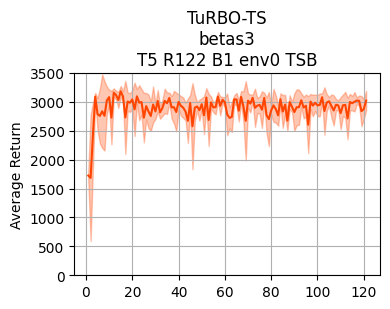

In [17]:
agent_name = 'TuRBO-TS'   # set agent name
result_experiment_TuRBO_TS, B_schedule = run_experiment(agent_name, **experiment_settings)  # run experiment
plot_batch_results(  # plot results
    agent_name, result_experiment_TuRBO_TS, output_detail, output_folder,
    **experiment_settings_plot,
    plot_title_detail=BO_PARAMS, chosen_B_schedule=B_schedule,
    fig_size=fig_size, y_lim=y_lim
)

# Run standard TS

running TS_prior experiments (trials=5 TRB=T5 R122 B1)...
finished TS_prior CHD env0 (betas3) trial0 duration = 19.5 sec
finished TS_prior CHD env0 (betas3) trial1 duration = 17.3 sec
finished TS_prior CHD env0 (betas3) trial2 duration = 17.1 sec
finished TS_prior CHD env0 (betas3) trial3 duration = 18.1 sec
finished TS_prior CHD env0 (betas3) trial4 duration = 16.8 sec


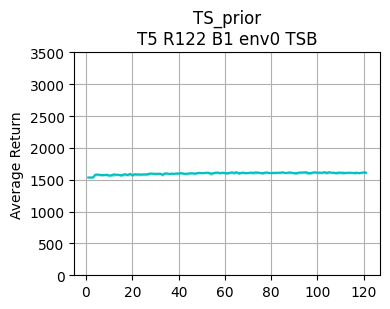

In [18]:
# standard TS version using new prior from BLR
experiment_settings['chosen_BO_PARAMS'] = None   # reset BO parameters
agent_name = 'TS_prior'   # set agent name
result_experiment_TS_prior, B_schedule = run_experiment(agent_name, **experiment_settings)  # run experiment
plot_batch_results(  # plot results
    agent_name, result_experiment_TS_prior, output_detail, output_folder,
    **experiment_settings_plot,
    chosen_B_schedule=B_schedule, fig_size=fig_size, y_lim=y_lim
)